In [4]:
%matplotlib inline
from math import *
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

### 以下でクラスを定義
#### **Componentクラス**  
各コンポーネント(パネルもコンポーネントとしている)の情報を持つ．主にコンポーネントの名前とコンポーネントが持つノードの数，各面の表面情報を持っている．
表面情報として，各面のε，α(内側外側両方)，その面が持つノードのID(begin_id, end_id)を持つ．**ini_surface** で面の方向を定義．

#### Spacecraftクラス  
Componentクラスのオブジェクトが入ったリストを受取り，コンポーネント間の関係，ノード情報を保持する．コンポ間の関係の情報としては，各ノード間の熱コンダクタンス，各コンポーネントの配置関係(コンポーネント間が熱交換を行う面がfrontかbackなのか)，view factorがある．ノード情報の中には質量，比熱，内部発熱，温度がある．  
**ini_node()** ではコンポーネントのリストからコンポーネント情報を受けとり，そこから宇宙機全体として持つノード数を計算，ノード情報の中にそのノードが属するコンポーネントの名前を追加している．  

#### Environmentクラス  
主に宇宙空間の情報，太陽やアルベドなどのフラックスの情報を持つクラス．宇宙空間が複数ノードになることは無いのかもしれないが，一応複数になることを想定して設計している(意味ないかも…)．Flux情報には入射方向が宇宙機固定3次元極座標の角度(Θ，Φ)で入力されるため，**calc_direction()** で直交座標系におけるベクトル情報に変換している．  

#### Thermal_equationクラス  
Thermal_equationについてのまとめ
初期化メソッド，熱伝導方程式から各ノードへの熱量を計算するメソッド，数値積分メソッド（オイラー，ルンゲクッタ4），時間ステップを伝搬するメソッドを持っている．コンストラクタの引数としてはSpacecraftインスタンス，Environmentインスタンス，伝搬時間刻み，ステップ数を取る．コンストラクタ内で，全体のノード数を計算(通常であれば宇宙は1ノードなのでSCのノード+1)，各種必要な変数をコピー，結果用配列の確保を行っている．  
- **dT_dt()**  
主に熱伝導方程式の計算をしており，対象のノードIDを受け取ってそのノードにおける温度の時間微分を返り値としている．内部の計算としてはノードiに属している面を**find_surface()** で洗い出し，各面における情報を取得．他のノードとの熱伝導は熱コンダクタンスが与えられているのでそれから計算している．  
一方で熱輻射に関しては，各ノードの中の各面の関係からview facorが決定するため，その関係を読み出すために各面について見ている．また，各面の表面特性(ε，α)は面の内側か外側かによって変化するため，コンポーネント間の関係を**find_relation()** 関数で洗い出し，その関係から表面特性を決定している．これらの値によって輻射伝熱量の計算を行っている．  
また，宇宙空間に対する放射は別途Spaceに対するviewがあるものだけを計算している．次に太陽などからのフラックスからの熱入射の計算を行う．フラックスの太陽輻射圧，入射方向は時間変化があることを想定しており，csvファイルで指定している．伝搬時刻から，フラックスの状態を読み出して入熱量を計算している．また，各ノードの内部発熱はノード内で保持している．これらのノードに対する入熱量[W]をノードの熱容量で割って，dT/dtを計算している．
- **RungeKutta4()**  
時刻tからt+1の積分を全てのノードをまとめて計算している．  

- **solve()**  
各ステップの時刻を計算すると同時に，伝搬を行っている．


In [29]:
#dfで与える．
class Component:
    def __init__(self, name, area_prop):
        self.node_num = area_prop.iat[-1,0] - area_prop.iat[0,0] + 1
        self.name = name
        self.surface = self.ini_surface(area_prop)

    #このノード数の追加いるかな？最初から入れとけばよくね？
    def ini_surface(self, area_prop):
        node_num = []
        for row in area_prop.itertuples():
            node_num.append(row.end_node-row.begin_node+1)
        area_prop["node_num"] = node_num
        direction = [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)] #PX,PY,PZ,MX,MY,MZの順
        area_prop["direction"] = direction
        return area_prop

#compo_list = [MISSION, BUS, PANEL]

#view prop以外はpandas
class Spacecraft:
    def __init__(self, Cij, in_out, view_prop, phys_prop, compo_list):
        self.node_number = 0 #ini_nodeで統合
        self.conductance = Cij
        self.compo_relation = in_out
        self.view_factor = view_prop
        self.compos = {i.name : i for i in compo_list}
        #self.size = size #sizeは小さい順に入力
        #self.node_id = list(surface_name_id.values())
        self.node = phys_prop
        self.ini_node()

    def ini_node(self): 
        Compos = []
        for name,compo in self.compos.items():
            Compos.append(name)
            self.node_number = self.node_number + compo.node_num #各コンポが持つノードを合計
        self.node["compo"] = Compos

    #時間ごとの環境変化（姿勢、熱）をアップデート
    #def update(self):
     #   self

class Environment:
    def __init__(self, node_num, flux, temperature):
        self.node_number = node_num
        self.node = []
        self.flux = flux #時間履歴とフラックス強さ，角度を格納，これもpandasにする．複数になったときのために[pandas,...]にしとこ
        self.calc_direction()
        self.ini_node(temperature)
    def ini_node(self, temperature):
        for i in range(self.node_number):
            self.node.append({"temperature[K]" : temperature[i]})

    def calc_direction(self):
        directions = []
        for i in range(len(self.flux)):
            for index, row in self.flux[i].iterrows():
                #初めからradでもいい気がするが．．
                phi_rad = radians(row["phi[deg]"])
                theta_rad = radians(row["theta[deg]"])
                directions.append((sin(phi_rad)*cos(theta_rad), sin(phi_rad)*sin(theta_rad), cos(phi_rad)))
            self.flux[i]["direction"] = directions

'''#ノードを辞書にしとけば方程式に与える時に求めるもの以外のノードをすぐに探せるから要修正
#各ノードにすぐアクセスできてかつ全てのノード情報を持つ，
class Node:
    def __init__(self, spacecraft, environment):
        self.all = spacecraft.node + environment.node
        self.node_number = spacecraft.node_number + environment.node_number
'''
#Space以外の全てのノードについて解くように変更する
class Thermal_equation:
    def __init__(self, SC, Env, dt, step):
        self.sc = SC
        #self.Node_i = SC.node[node_id]
        self.N = SC.node_number + Env.node_number
        self.dt = dt
        self.t = 0 #時刻
        self.step = step
        self.T = dt*step
        self.k = 0 #Runge_Kuttaの係数
        self.env = Env
        self.answer = np.zeros((self.N-1, self.step)) #答え格納

    def find_surface(self, k):
        compo = self.sc.node.at[k,"compo"] #compoの名前
        surfaces = []
        for surface, row in self.sc.compos[compo].surface.iterrows():
            if (k >= row["begin_node"] and k <= row["end_node"]):
                surfaces.append((surface, float(row["area"])))
        return compo, surfaces #compoの名前と[(面の名前,area),...]をタプルで返す

    def find_relation(self, i, j):
        compo_i = self.sc.node.at[i,"compo"] #compoの名前
        compo_j = self.sc.node.at[j,"compo"] #compoの名前
        relation = self.sc.compo_relation.at[compo_i, compo_j]
        #out-out
        if relation == 1:
            return ("out", "out")
        #out-in
        elif relation == 2:
            return ("out", "in")
        #in-out
        elif relation == 3:
            return ("in", "out")
        elif relation == 99:
            return ("no_relationship", "no_relationship")

    def dT_dt(self, i):
        sigma = 5.67 * 10**(-8)
        trans_sum = 0
        radiation_sum = 0
        Node_i = self.sc.node.loc[i,:]
        i_surfaces = self.find_surface(i)
        capa = Node_i["weight[kg]"]*Node_i["capacity[J/K/kg]"]
        #各面について
        for S_i in i_surfaces[1]:
            i_surface = i_surfaces[0] + "_" + S_i[0]
            #どちらも一緒か試す。どっちでもええ
            Ai = S_i[1]
            #Ai = self.sc.compos[i_surfaces[0]].surface.at[S_i,"area"]
            #熱伝達と輻射量を計算
            for j in range(len(self.sc.node)):
                j = j+1 #nodeIDにあわせる
                Node_j = self.sc.node.loc[j,:]
                Rij = 0
                #indexでのアクセスはnodeID-1
                trans_sum = trans_sum + self.sc.conductance.iat[i-1,j-1]*(Node_i["temperature[K]"] + self.k - Node_j["temperature[K]"])
                #以下，熱放射を考える．
                j_surfaces = self.find_surface(j)
                #find relationを作る．
                node_relation = self.find_relation(i,j)
                #print(node_relation)
                if (node_relation[0]=="no_relationship"):
                    alpha_i, epsilon_i, epsilon_j = (0,0,0)
                else:
                    i_alpha_id = "alpha_" + node_relation[0]
                    i_epsilon_id = "epsilon_" + node_relation[0]
                    j_alpha_id = "alpha_" + node_relation[1]
                    j_epsilon_id = "epsilon_" + node_relation[1]
                for S_j in j_surfaces[1]:
                    if (node_relation[0]=="no_relationship"):
                        continue
                    else:
                        alpha_i = self.sc.compos[i_surfaces[0]].surface.at[S_i[0],i_alpha_id]
                        epsilon_i = self.sc.compos[i_surfaces[0]].surface.at[S_i[0],i_epsilon_id]
                        alpha_j = self.sc.compos[j_surfaces[0]].surface.at[S_j[0],j_alpha_id]
                        epsilon_j = self.sc.compos[j_surfaces[0]].surface.at[S_j[0],j_epsilon_id]
                    #BUS_PXのように固有の面情報を作る．view factorアクセス用, view factorは辞書
                    j_surface = j_surfaces[0] + "_" + S_j[0]
                    Fij = self.sc.view_factor[(i,i_surface)][(j,j_surface)]
                    Rij = Rij + epsilon_i*epsilon_j*Fij*Ai
                radiation_sum = radiation_sum + sigma*Rij*((Node_i["temperature[K]"] + self.k)**4 - Node_j["temperature[K]"]**4)
                #print("Rij:",Rij)
                #print(radiation_sum)
                #print(i, j, alpha_i, epsilon_i, epsilon_j)
            #宇宙空間に対する放射も考える．
            Fi_space = self.sc.view_factor[(i,i_surface)][(self.N,"SPACE")]
            #ここのε違う，Spaceに対するものに変更
            epsilon_i = self.sc.compos[i_surfaces[0]].surface.at[S_i[0],"epsilon_out"]
            Ri_space = epsilon_i*1*Fi_space*Ai
            #print("Ri_space:",Ri_space)
            buff = ((Node_i["temperature[K]"] + self.k)**4 - self.env.node[0]["temperature[K]"]**4)
            radiation_sum = radiation_sum + sigma*Ri_space*buff
        #外部熱入力を計算
        #print(Node_i["temperature[K]"])
        Qin = 0
        for F in self.env.flux:
            #この時刻におけるフラックスを探す
            begin = 0
            for index, row in F.iterrows():
                #ここbegin endにしなくても一列に時間並べていれば計算できるはずやが．
                end = row["time[s]"]
                #begin = row["begin_time[s]"]
                #end = row["end_time[s]"]
                if (self.t >= begin) and (self.t <= end):
                    f = row
                    break
                else:
                    f = pd.DataFrame(index=[],columns=F.columns)
                begin = row["time[s]"]
            if f.empty:
                break
            compo_name, Surfaces = i_surfaces
            for S in Surfaces: #各面の情報を取り出す S=(PX,area)
                alpha_i = self.sc.compos[compo_name].surface.at[S[0],"alpha_out"]
                N_direction = self.sc.compos[compo_name].surface.at[S[0],"direction"]
                f_dot_n =0 #Fluxベクトルと面の法線ベクトルの内積を初期化
                for f_d, s_d in zip(f["direction"], N_direction):
                    f_dot_n = f_dot_n + f_d*s_d #Fluxベクトルと面の法線ベクトルの内積
                if f_dot_n < 0: #内積が負のときは入力がある
                    Qin = Qin - f["flux[W/m2]"]*f_dot_n*alpha_i*S[1]
                else:
                    Qin = Qin
            #内部発熱
        q_internal = Node_i["internal_heat[W]"]
        #print(trans_sum)
        return (Qin + q_internal - trans_sum - radiation_sum)/capa
    
    #定常
    #def Newton_method(self):    

    #これは使用しない
    def Euler(self):
        Ti = np.empty(self.step)
        for i in range(self.step):
            Ti[i] = self.Node_i["temperature"]
            self.Node_i["temperature"] = self.Node_i["temperature"] + self.dT_dt()*self.dt
        return Ti

    #時間tにおける積分をまとめて行う(t+1を求める)．
    def RungeKutta4(self):
        Tt = []
        dT = 0
        #space以外で回す
        for i in range(1,self.N):
            Ti = float(self.sc.node.at[i,"temperature[K]"])
            k1 = self.dt*self.dT_dt(i)
            self.k = k1/2
            k2 = self.dt*self.dT_dt(i)
            self.k = k2/2
            k3 = self.dt*self.dT_dt(i)
            self.k = k3
            k4 = self.dt*self.dT_dt(i)
            dT = (k1 + 2*k2 + 2*k3 + k4)/6
            Tt.append(Ti)
            #print(dT)
            self.sc.node.at[i,"temperature[K]"] = Ti + dT
        #print(Tt)
        return Tt

    #この中でフラックス情報アップデート，RK4回す
    def solve(self):
        for s in range(self.step):
            self.t = self.dt*s
            self.answer[:,s] = self.RungeKutta4()
            #print(s)
            #print(self.RungeKutta4())
            #print(self.answer[:,s])
        #print(self.answer[:,-1])
    
    def make_log(self, file_name):
        answer_pd = pd.DataFrame(self.answer)
        path = 'log/' + file_name
        answer_pd.to_csv(path)
        


def Plot(ther_eq, title_name, directory):
    plt.figure(figsize=(10,5))
    Answer = ther_eq.answer
    T_plot = [i*ther_eq.dt for i in range(ther_eq.step)]
    plt.xlabel("time[s]")
    plt.ylabel("T[K]")
    legend = [i for i in ther_eq.sc.compos.keys()]
    for i in range(len(Answer)):
        plt.plot(T_plot,Answer[i,:], label = legend[i])
    plt.legend()
    plt.grid()
    plt.title(title_name)
    path = "figure/" + directory + title_name + "_deg.png"
    plt.savefig(path)
    plt.show()

#### 初期化のためのCSVファイルを読み込む
- Cij.csv  
各ノード同士の熱コンダクタンスを保持
- area_properties/"component name".csv  
コンポーネントごとの各面の情報を保持．その面が持つ初めのノードIDと終わりのノードID，面の内側と外側のε，αを持っている．
- in_out_properties.csv  
各コンポーネント間の配置関係を保持．各数字の意味としては
    - 1：両方の面の外側の面の情報を使用．
    - 2：行のコンポの外側の面，列のコンポの内側の面の情報を使用．つまり列のコンポーネントの中に行のコンポーネントがあるという位置関係．
    - 3：行のコンポの内側の面，の列のコンポの外側の面情報を使用．つまり行のコンポーネントの中に列のコンポーネントがあるという位置関係．
    - 99：コンポーネント間にviewが存在しない．
- physical_properties.csv  
各ノードのID，質量[kg]，比熱[J/K/kg]，内部発熱[W]，温度[K]を保持．温度に関しては実数で記入しないとintにキャストされて計算がうまくいかない．
- outer_flux.csv  
フラックスの輻射圧[W/m$^2$]，機体固定3次元極座標系における入射角度Θ[deg]，Φ[deg]を保持．これらが時間変化することを考えて，ある値に対してその状態の開始時刻と終了時刻も保持している．
現在は太陽フラックスのみしか考慮していないが，アルベド等についても同様のファイルを作ることによってフラックスを考えることができる．

以上のファイルに関してはpandasのDataFrameとして読み込み扱う．  
- view_properties.csv  
各ノードの各面ごとにview factorを持つ．各コンポーネント固有の面であることを表すために**PANEL_PX**のようにコンポーネントの名前と面の方向で面の名前を表現している．この情報に関しては，keyをノードIDと面の名前をまとめたタプル((1,PANEL_PX)のような形)で定義した辞書としてview factorを保持している．DataFrameではタプルをヘッダーにすることはできなさそうだったので辞書型としているが，改善の余地あり．


In [61]:
Cij = pd.read_csv('thermal_config/Cij_2.csv', index_col=0) #各ノードについて
panel_area = pd.read_csv('thermal_config/area_properties/PANEL.csv', index_col=0)
bus_area = pd.read_csv('thermal_config/area_properties/BUS.csv', index_col=0)
navigation_area = pd.read_csv('thermal_config/area_properties/NAVIGATION.csv', index_col=0)
communication_area = pd.read_csv('thermal_config/area_properties/COMMUNICATION.csv', index_col=0)
propulsion_area = pd.read_csv('thermal_config/area_properties/PROPULSION.csv', index_col=0)
in_out_prop = pd.read_csv('thermal_config/in_out_properties.csv', index_col=0)
#phys_prop = pd.read_csv('thermal_config/physical_property/operation.csv')
phys_prop = pd.read_csv('thermal_config/physical_property/orbit_control.csv')
phys_prop.index = phys_prop.index + 1 #nodeと一致させる

season = 'summer'
right_ascension = '0'
ID = season + '_' + right_ascension
file_name = 'thermal_config/flux/outer_flux_' + ID + '.csv' 
solar_flux = pd.read_csv(file_name)
directory = 'orbit_control/'

#view propertyだけ辞書型にする
with open('thermal_config/view_properties.csv') as f:
    reader = csv.reader(f)
    view_list = [row for row in reader]
view_key1 = [(int(i),j) for i,j in zip(view_list[0][2:],view_list[1][2:])]
view_key2 = view_key1[:-1]
view_prop = {}
for i in range(len(view_key2)):
    view_values = {}
    for j in range(len(view_key1)):
        #print(i,j,view_list[2+i][2+j])
        view_values[view_key1[j]] = float(view_list[2+i][2+j])
    view_prop[view_key2[i]] = view_values
#print(view_prop)
#view_prop = pd.read_csv('thermal_config/view_properties.csv', index_col=0)
#view_prop
#bus_area
#phys_prop
#solar_flux

#size = (0.10, 0.20, 0.30) #m 6U
#SC_temperature = (25.0 + 273,) #K

Unv_node_num = 1
Unv_temperature = (-270 + 273,) #K

#Envにおけるheatをしっかり定義，このフラックス方向の変化刻みと伝搬における刻み幅は独立させる．
fluxes = [solar_flux]

dt = 100 #[s]
#T = 3000 #[s]
step = 250

BUS = Component("BUS", bus_area)
PANEL = Component("PANEL", panel_area)
NAVIGATION = Component("NAVIGATION", navigation_area)
COMMUNICATION = Component("COMMUNICATION", communication_area)
PROPULSION = Component("PROPULSION", propulsion_area)

compo_l = [PANEL, BUS, NAVIGATION, COMMUNICATION, PROPULSION]

SC = Spacecraft(Cij, in_out_prop, view_prop, phys_prop, compo_l)
#print(SC.node)
Env = Environment(Unv_node_num, fluxes, Unv_temperature)
#Node()
Ther_eq = Thermal_equation(SC, Env, dt, step)
Ther_eq.solve()
Ther_eq.make_log(directory + ID + '.csv')
#print(Ther_eq.f())


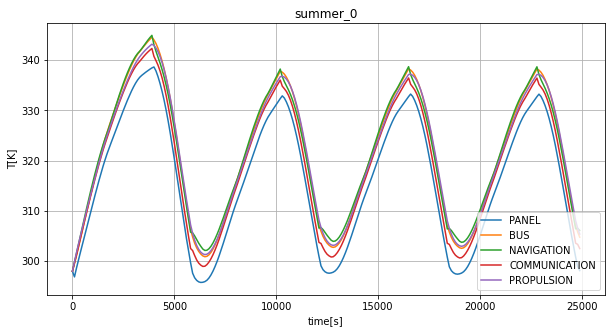

In [62]:
Plot(Ther_eq,ID,directory)